In [ ]:
# https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html
# mount filesystem and install requirements
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/ONR
#!pip install pytorch dgl==0.4.3 rdflib dglke!pip install pytorch dgl==0.4.3 rdflib dglke
!pip install stellargraph rdflib > /dev/null #dglke
import pandas as pd
#import dglke
import torch as th
import pickle
import numpy as np
import stellargraph as sg

Mounted at /content/gdrive
/content/gdrive/MyDrive/ONR


In [ ]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal
import networkx as nx
from networkx.classes.function import info
import stellargraph as sg
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import sklearn
from sklearn import model_selection
from collections import Counter
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

# dataset = datasets.AIFB()
# display(HTML(dataset.description))
# G, affiliation = dataset.load()
# train_targets, test_targets = model_selection.train_test_split(
#     affiliation, train_size=0.8, test_size=None
# )
# print(G.info())
# list(G.nodes)
# generator = RelationalFullBatchNodeGenerator(G, sparse=True)
# train_gen = generator.flow(train_targets.index, targets=train_targets)
# test_gen = generator.flow(test_targets.index, targets=test_targets)
#xx

In [ ]:
#graph_labels = pd.get_dummies(graph_labels, drop_first=True)
#dict(G.nodes())
# summary = pd.DataFrame(
#   [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
#   columns=["nodes", "edges"],
# )
# summary.describe().round(1)

In [ ]:
#!head /content/gdrive/MyDrive/ONR/wq14+times.pkl
#x = pd.read_csv('/content/gdrive/MyDrive/ONR/wqsample14-test.tsv')
# import pickle
# with open('/content/gdrive/MyDrive/ONR/wq14+times.pkl', 'rb') as f:
#   x = pickle.load(f) 
# x.head(4) #195 rows


In [ ]:
# if 'samples_train' not in globals():

# s = pd.read_csv('/content/gdrive/MyDrive/ONR/wqsample14-train.tsv', sep='\t', header=None)
# samples_train = s.rename(columns={0: 'source', 2: 'target', 1: 'label'})
# samples_train = samples_train.sample(frac=0.2)

# s = pd.read_csv('/content/gdrive/MyDrive/ONR/wqsample14-valid.tsv', sep='\t', header=None)
#samples_valid = s.rename(columns={0: 'source', 2: 'target', 1: 'label'})
# just fecal coliform
#samples_valid = samples_valid[samples_valid['label'] == 'ex:hasCharacteristicName']

# s = pd.read_csv('/content/gdrive/MyDrive/ONR/wqsample14-test.tsv', sep='\t', header=None)
# samples_test = s.rename(columns={0: 'source', 2: 'target', 1: 'label'})

s = pd.read_csv('/content/gdrive/MyDrive/ONR/wqsample14-valid.tsv', sep='\t', header=None) #full
#s = s.sample(frac=0.2)

##
# encoding
# s[2] = s[2].str.replace('ex:\w+-', '', regex=True)
# s.loc[s[1] == 'sosa:hasSimpleResult', 2] = s.loc[s[1] == 'sosa:hasSimpleResult', 2].astype(int) / 10
# s.loc[s[1] == 'ex:hasTimeDelta', 2] = s.loc[s[1] == 'ex:hasTimeDelta', 2].astype(int) / 8766
# s.loc[s[1] == 'ex:hasTimeMonth', 2] = s.loc[s[1] == 'ex:hasTimeMonth', 2].astype(int) / 12
# s.loc[s[1] == 'ex:hasTimeWeek', 2] = s.loc[s[1] == 'ex:hasTimeWeek', 2].astype(int) / 52
# s.loc[s[1] == 'ex:hasTimeDay', 2] = s.loc[s[1] == 'ex:hasTimeDay', 2].astype(int) / 31
# from sklearn.preprocessing import LabelEncoder
# s.loc[s[1] == 'ex:hasCharacteristicName', 2] = LabelEncoder().fit_transform(s.loc[s[1] == 'ex:hasCharacteristicName', 2])
##

samples_full = s.copy().rename(columns={0: 'source', 2: 'target', 1: 'label'})

# negative graph /1
# every result make simpleResult as far away as possible, if 1, then 9; 2 then 9; 6 then 1; 7 then 1...
# n.g. /2
# every target points to source
# 25% vs 22%
samples_negative = s.copy().rename(columns={2: 'source', 0: 'target', 1: 'label'})

# g_train = sg.StellarDiGraph(
#   edges=samples_train, edge_type_column='label'
# )
# g_valid = sg.StellarDiGraph(
#   edges=samples_valid, edge_type_column='label'
# )
# g_test = sg.StellarDiGraph(
#   edges=samples_test, edge_type_column='label'
# )

#simple_result = samples_full.pop('sosa:hasSimpleResult')

all_nodes = pd.concat([samples_full.source, samples_full.target])
nodes = pd.DataFrame(index=pd.unique(all_nodes))
# create 1 feature
nodes['is_source_node'] = [ 1 for i in pd.unique(samples_full.source) ] + [ 0 for i in pd.unique(samples_full.target) ]

g_full = sg.StellarDiGraph(
  nodes,
  edges=samples_full, edge_type_column='label'
)

# too much memory
#all_nodes = pd.concat([samples_full.source, samples_full.target])
#nodes = pd.DataFrame(index=pd.unique(all_nodes))
#nodes_onehot_features = pd.get_dummies(nodes.index).set_index(nodes.index)
# g_full = sg.StellarDiGraph(
#   nodes_onehot_features,
#   edges=samples_full, edge_type_column='label'
# )

# samples_valid.tail(10)
print(g_full.info())
print(len(samples_full))

# valid 668k, test 5k

StellarDiGraph: Directed multigraph
 Nodes: 668811, Edges: 6515780

 Node types:
  default: [668811]
    Features: float32 vector, length 1
    Edge types: default-a->default, default-ex:hasCharacteristicName->default, default-ex:hasLocation->default, default-ex:hasResultMeasureMeasureUnitCode->default, default-ex:hasResultSampleFractionText->default, ... (5 more)

 Edge types:
    default-sosa:hasSimpleResult->default: [651578]
        Weights: all 1 (default)
        Features: none
    default-ex:hasTimeWeek->default: [651578]
        Weights: all 1 (default)
        Features: none
    default-ex:hasTimeMonth->default: [651578]
        Weights: all 1 (default)
        Features: none
    default-ex:hasTimeDelta->default: [651578]
        Weights: all 1 (default)
        Features: none
    default-ex:hasTimeDay->default: [651578]
        Weights: all 1 (default)
        Features: none
    default-ex:hasResultSampleFractionText->default: [651578]
        Weights: all 1 (default)
       

In [ ]:
#samples_negative = s.rename(columns={2: 'source', 0: 'target', 1: 'label'})
#samples_negative.head(20)
samples_full.head(10)

,source,label,target
0,ex:sample-2127519,a,sosa:Observation
1,ex:sample-2127519,ex:hasCharacteristicName,ex:cn-Kjeldahl nitrogen
2,ex:sample-2127519,ex:hasResultSampleFractionText,ex:ft-Total
3,ex:sample-2127519,ex:hasResultMeasureMeasureUnitCode,ex:un-mg/l
4,ex:sample-2127519,sosa:hasSimpleResult,ex:sr-6
5,ex:sample-2127519,ex:hasTimeDelta,ex:td-6000
6,ex:sample-2127519,ex:hasTimeMonth,ex:td-9
7,ex:sample-2127519,ex:hasTimeWeek,ex:td-37
8,ex:sample-2127519,ex:hasTimeDay,ex:td-8
9,ex:sample-2127519,ex:hasLocation,ex:ln-MNPCA-27-0104-00-201


In [ ]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from tensorflow.keras import layers, optimizers, losses, metrics, Model

epochs = 20

# G = g_full
# edge_splitter_test = EdgeSplitter(G)
# G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
#   p=0.3, method="global", keep_connected=False, seed=0
# )
# G_train, edge_ids_train, edge_labels_train = edge_splitter_test.train_test_split(
#   p=0.99999, method="global", keep_connected=False, seed=0
# ) ####### 1.0 broken!?????
# train_gen = FullBatchLinkGenerator(G_train, method="gcn")
# train_flow = train_gen.flow(edge_ids_train, edge_labels_train)
# test_gen = FullBatchLinkGenerator(G_test, method="gcn")
# test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

# print('edge_ids_test:',edge_ids_test)
# print('edge_labels_test:',edge_labels_test)
# array of arrays [[n1 n2], [n1 n3], [n1 n4], ...]
# edge_ids_test: [['ex:sample-2783264' 'ex:ln-21FLPBCH_WQX-70']
#  ['ex:sample-2780822' 'ex:td-29']
#  ['ex:sample-2782351' 'ex:ft-Dissolved']
#  ['ex:sample-2781290' 'ex:ln-21NC03WQ-C7000000']
#  ['ex:sample-2780444' 'ex:sample-2779685']
#  ['ex:sample-2783225' 'ex:sample-2781982']
#  ['ex:sample-2781404' 'ex:sample-2781057']
#  ['ex:sample-2783182' 'ex:td-8750']]
# edge_labels_test: [1 1 1 1 0 0 0 0]

max = int(len(samples_full) * 0.8) #
max2 = int(len(samples_full) * 0.8) + int(len(samples_full) * 0.1)
len2 = max2 - max

pos_train = samples_full[['source', 'target']][0:max]
neg_train = samples_negative[['source', 'target']][0:max]

edge_ids_train = pd.concat([samples_full[['source', 'target']][0:max],
  samples_negative[['source', 'target']][0:max]]).to_numpy()
edge_labels_train = [1 for i in range(0, max, 1)] +\
  [0 for i in range(0, max, 1)]

edge_ids_valid = pd.concat([samples_full[['source', 'target']][max:max2],
  samples_negative[['source', 'target']][max:max2]]).to_numpy()
edge_labels_valid = [1 for i in range(0, len2, 1)] +\
  [0 for i in range(0, len2, 1)]

edge_ids_test = pd.concat([samples_full[['source', 'target']][max2:],
  samples_negative[['source', 'target']][max2:]]).to_numpy()
edge_labels_test = [1 for i in range(0, len(samples_full) - max2, 1)] +\
  [0 for i in range(0, len(samples_full) - max2, 1)]

print('max', max, 'max2', max2, 'len2', len2, 'samples_full', len(samples_full))

gen = FullBatchLinkGenerator(g_full, method="gcn")
train_flow = gen.flow(edge_ids_train, edge_labels_train)
valid_flow = gen.flow(edge_ids_valid, edge_labels_valid)
test_flow = gen.flow(edge_ids_test, edge_labels_test)

gcn = GCN(
  # layer_sizes=[32, 32], activations=["relu", "relu"], generator=train_gen, dropout=0.3
  layer_sizes=[16, 16], activations=["relu", "relu"], generator=gen, dropout=0.3
)
x_inp, x_out = gcn.in_out_tensors()

prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)
model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
  optimizer=keras.optimizers.Adam(lr=0.1), #.01
  loss=keras.losses.binary_crossentropy,
  metrics=["mean_squared_error"],#acc
)

init_train_metrics = model.evaluate(train_flow)
init_valid_metrics = model.evaluate(valid_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValid Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_valid_metrics):
    print("\t{}: {:0.4f}".format(name, val))

# msqe
#73 w/ enc
#53 w/o enc!

max 5212624 max2 5864202 len2 651578 samples_full 6515780
Using GCN (local pooling) filters...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 214ms/step - loss: 6.2319 - mean_squared_error: 55.0492

Train Set Metrics of the initial (untrained) model:
	loss: 6.3500
	mean_squared_error: 63.4464

Valid Set Metrics of the initial (untrained) model:
	loss: 6.2319
	mean_squared_error: 55.0492


In [ ]:
history = model.fit(
  train_flow, epochs=epochs, validation_data=valid_flow, verbose=2, shuffle=False
)
# xx
# msqe
# 22 w/ enc!
# 22 w/o enc!

Epoch 1/20
1/1 - 2s - loss: 6.2437 - mean_squared_error: 48.9550 - val_loss: 4.6080 - val_mean_squared_error: 2.5404 - 2s/epoch - 2s/step
Epoch 2/20
1/1 - 1s - loss: 5.0549 - mean_squared_error: 3.2010 - val_loss: 1.8282 - val_mean_squared_error: 0.4689 - 579ms/epoch - 579ms/step
Epoch 3/20
1/1 - 1s - loss: 2.7152 - mean_squared_error: 0.4655 - val_loss: 0.9641 - val_mean_squared_error: 0.3479 - 583ms/epoch - 583ms/step
Epoch 4/20
1/1 - 1s - loss: 0.9701 - mean_squared_error: 0.3487 - val_loss: 1.4549 - val_mean_squared_error: 0.3275 - 583ms/epoch - 583ms/step
Epoch 5/20
1/1 - 1s - loss: 1.5698 - mean_squared_error: 0.3483 - val_loss: 0.7368 - val_mean_squared_error: 0.2709 - 590ms/epoch - 590ms/step
Epoch 6/20
1/1 - 1s - loss: 0.7375 - mean_squared_error: 0.2711 - val_loss: 0.6934 - val_mean_squared_error: 0.2501 - 585ms/epoch - 585ms/step
Epoch 7/20
1/1 - 1s - loss: 0.6965 - mean_squared_error: 0.2516 - val_loss: 0.7269 - val_mean_squared_error: 0.2663 - 588ms/epoch - 588ms/step
Epoc

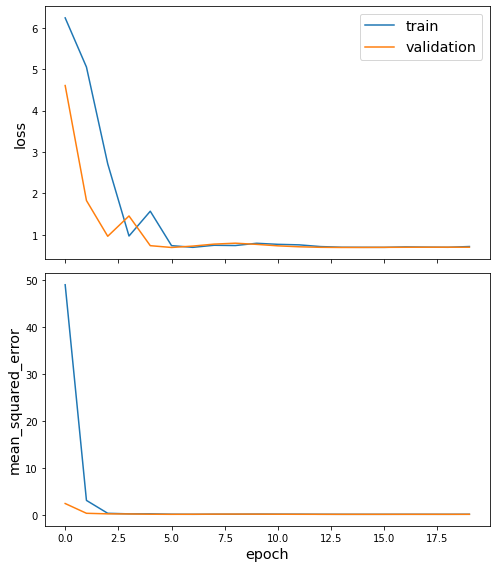

In [ ]:
sg.utils.plot_history(history)

In [ ]:
# Q: How to check MSE of individual relations (eg a, charname, ...)

train_metrics = model.evaluate(train_flow)
valid_metrics = model.evaluate(valid_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValid Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, valid_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 215ms/step - loss: 0.6992 - mean_squared_error: 0.2530

Train Set Metrics of the trained model:
	loss: 0.6992
	mean_squared_error: 0.2530

Valid Set Metrics of the trained model:
	loss: 0.6993
	mean_squared_error: 0.2531

Test Set Metrics of the trained model:
	loss: 0.6992
	mean_squared_error: 0.2530


In [ ]:
train = samples_full[max2:]
fc_source = np.unique(train[
  (train['label'] == 'ex:hasCharacteristicName') &\
  (train['target'] == 'ex:cn-Fecal Coliform')]['source'])
#fc_sr = train[(train['source'].isin(fc_source)) & (train['label'] == 'sosa:hasSimpleResult')]
fc_sr = train[train['source'].isin(fc_source)]

#fc = fc[(fc['label'] == 'ex:hasCharacteristicName') & (fc['target'] == 'ex:cn-Fecal Coliform')]

pos_test = fc_sr[['source', 'target']]
neg_test = samples_negative[['source', 'target']][max2:max2+len(fc_sr)]

edge_ids_test_fc = pd.concat([fc_sr[['source', 'target']],
  samples_negative[['source', 'target']][max2:max2+len(fc_sr)]]).to_numpy()
edge_labels_test_fc = [1 for i in range(0, len(fc_sr), 1)] +\
  [0 for i in range(0, len(fc_sr), 1)]

#print('max', max, 'max2', max2, 'len2', len2, 'samples_full', len(samples_full))
print('fc', len(fc_sr))

test_fc_flow = gen.flow(edge_ids_test_fc, edge_labels_test_fc)

test_fc_metrics = model.evaluate(test_fc_flow)

print("\nTest Set Metrics of the trained model (fc):")
for name, val in zip(model.metrics_names, test_fc_metrics):
    print("\t{}: {:0.4f}".format(name, val))


fc 19100
1/1 [==============================] - 0s 200ms/step - loss: 0.7072 - mean_squared_error: 0.2570

Test Set Metrics of the trained model (fc):
	loss: 0.7072
	mean_squared_error: 0.2570


In [ ]:
aa = model.predict(test_fc_flow, verbose=1)
# np.max(a)
# len(a[0])
a = aa.squeeze()

print(edge_ids_test_fc)

df = pd.DataFrame({"Predicted": a, "True": a})
df.tail(20)



#for i in np.nditer(model.predict(test_fc_flow, verbose=1)):
#  print(i)

1/1 [==============================] - 0s 223ms/step
[['ex:sample-2714514' 'sosa:Observation']
 ['ex:sample-2714514' 'ex:cn-Fecal Coliform']
 ['ex:sample-2714514' 'ex:ft-Total']
 ...
 ['ex:ln-TCEQMAIN-10462' 'ex:sample-2715848']
 ['sosa:Observation' 'ex:sample-2715849']
 ['ex:cn-Ammonia-nitrogen' 'ex:sample-2715849']]


,Predicted,True
38180,0.443189,0.443189
38181,0.443319,0.443319
38182,0.443612,0.443612
38183,0.447532,0.447532
38184,0.443432,0.443432
38185,0.443950,0.443950
38186,0.443234,0.443234
38187,0.462823,0.462823
38188,0.446757,0.446757
38189,0.448056,0.448056


In [ ]:
def operator_l2(u, v):
  return (u - v) ** 2

binary_operator = operator_l2

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def link_examples_to_features(link_examples, transform_node):
  op_func = (
    operator_func[binary_operator]
    if isinstance(binary_operator, str)
    else binary_operator
  )
  return [
    op_func(transform_node(src), transform_node(dst)) for src, dst in link_examples
  ]

def link_prediction_classifier(max_iter=2000):
  lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
  return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

def evaluate_roc_auc(clf, link_features, link_labels):
  predicted = clf.predict_proba(link_features)

  # check which class corresponds to positive links
  positive_column = list(clf.classes_).index(1)
  return roc_auc_score(link_labels, predicted[:, positive_column])

def labelled_links(positive_examples, negative_examples):
  return (
    positive_examples + negative_examples,
    np.repeat([1, 0], [len(positive_examples), len(negative_examples)]),
  )

unseen_node_embedding = np.zeros(16)
def temporal_embedding(u):
  try:
    return temporal_model.wv[u]
  except KeyError:
    return unseen_node_embedding

def static_embedding(u):
  return static_model.wv[u]

link_examples, link_labels = labelled_links(pos_train, neg_train)
link_examples_test, link_labels_test = labelled_links(pos_test, neg_test)

temporal_clf = link_prediction_classifier()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
  link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
  temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")

ValueError: ignored

In [ ]:
# h_true = plt.hist(edge_ids_test_fc, bins=30, facecolor="green", alpha=0.5)
# h_pred = plt.hist(aa, bins=30, facecolor="blue", alpha=0.5)
# plt.xlabel("ranking")
# plt.ylabel("count")
# plt.legend(("True", "Predicted"))
# plt.show()

In [ ]:
len(test_fc_flow[0][0][0][0])
test_fc_flow[0][0][0][0]#[0]